In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("ion_manager/ion_predictor")



In [4]:
from ion_manager.ion_predictor.ml import pretrain_descriptors 
from ion_manager.ion_predictor.ml.auto_trainer import auto_prepare_model
from ion_manager.ion_predictor.ml.NeuralDescriptor import NeuralDescriptor
import yaml
import joblib

setting_path="settings.yaml"

with open(setting_path) as file:
    settings= yaml.safe_load(file)


Using backend: pytorch


In [5]:
#dump pretraining descriptor data from SMILES data
pretrain_descriptors.dump(settings)

100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
 10%|█         | 21/200 [00:02<00:17,  9.96it/s]

Epoch 20, loss 0.7770


 20%|██        | 41/200 [00:04<00:16,  9.58it/s]

Epoch 40, loss 0.6814


 30%|███       | 61/200 [00:06<00:14,  9.87it/s]

Epoch 60, loss 0.6184


 41%|████      | 82/200 [00:08<00:11, 10.04it/s]

Epoch 80, loss 0.6131


 51%|█████     | 102/200 [00:10<00:09,  9.89it/s]

Epoch 100, loss 0.5762


 60%|██████    | 121/200 [00:12<00:07, 10.17it/s]

Epoch 120, loss 0.5345


 71%|███████   | 142/200 [00:14<00:05, 10.01it/s]

Epoch 140, loss 0.5285


 81%|████████  | 162/200 [00:16<00:03, 10.09it/s]

Epoch 160, loss 0.5223


 91%|█████████ | 182/200 [00:18<00:01, 10.09it/s]

Epoch 180, loss 0.6294


100%|██████████| 200/200 [00:20<00:00,  9.94it/s]

Epoch 200, loss 0.5842


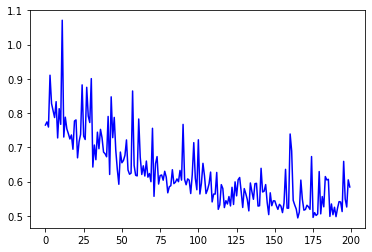

In [12]:
#train gnn model
auto_prepare_model(settings)

In [4]:
from ion_manager.ion_predictor.composite.auto_data_preparer import load_ion_excel
parsed_df=load_ion_excel(settings)

/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/data1/python/git/ion_predictor/ion_predictor/composite/DataUtility.py:115: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


In [5]:
y_label=settings["y_label"]

In [6]:
from ion_manager.ion_predictor.ml.regressor import initiate_regressor
from ion_manager.ion_predictor.ml.dataset_utils import get_number_and_category_cols 

number_columns,category_columns=get_number_and_category_cols(parsed_df,y_label)
model=initiate_regressor(number_columns,category_columns)

In [7]:
X=parsed_df.drop([y_label,"ID"],axis=1)
X=X.sort_index(axis=1, ascending=False)
y=parsed_df[[y_label]]
X_columns=list(X.columns)

In [8]:
model.fit(X,y)
joblib.dump([model,X_columns],settings["regressor_path"])

/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


['cache/regressor.bin']

In [9]:
import numpy as np
test_df=load_ion_excel(settings,composite_sheet_name="DatabaseForTest")
test_X=test_df.drop([y_label,"ID"],axis=1)
test_y=test_df[[y_label]]

lacking_columns=set(X_columns)-set(test_X.columns)
for c in lacking_columns:
    test_X[c]=np.nan
test_X=test_X.sort_index(axis=1, ascending=False)

/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/data1/python/git/ion_predictor/ion_predictor/composite/DataUtility.py:115: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


In [10]:
pred_y=model.predict(test_X)

/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Text(-10, -1, 'MAE: 1.14')

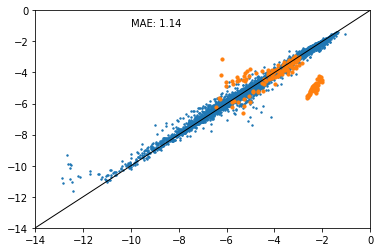

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score


ax=plt

model.fit(X,y)
pred_train_y=model.predict(X)
pred_test_y=model.predict(test_X)

ax.scatter(y,pred_train_y,s=2)
ax.scatter(test_y,pred_test_y,s=10)
plt.xlim(-14,0)
plt.ylim(-14,0)
ax.plot((-14,0),(-14,0),c="black",linewidth=1)

test_mae=mean_absolute_error(test_y,pred_test_y)
ax.text(-10,-1,f"MAE: {test_mae:.2f}")